# Linear Regression

In this tutorial, we are going to demonstrate how to use the `abess` package to carry out best subset selection 
in linear regression with both simulated data and real data.

## Linear Regression

Our package `abess` implement a polynomial algorithm in the for best-subset selection problem:

$$
\min_{\beta\in \mathbb{R}^p} \frac{1}{2n} ||y-X\beta||^2_2,\quad \text{s.t.}\ ||\beta||_0\leq s,
$$

where $\| \cdot \|_2$ is the $\ell_2$ norm, $\|\beta\|_0=\sum_{i=1}^pI( \beta_i\neq 0)$ is the $\ell_0$ norm of $\beta$, and the sparsity level $s$ is usually an unknown non-negative integer.
Next, we present an example to show how to use the `abess` package to solve a simple problem. 

## Simulated Data Example

### Fixed Support Size Best Subset Selection

We generate a design matrix $X$ containing 300 observation and each observation has 1000 predictors. The response variable $y$ is linearly related to the first, second, and fifth predictors in $X$:

$$y = 3X_1 + 1.5X_2 + 2X_5 + \epsilon,$$

where $\epsilon$ is a standard normal random variable. 

In [2]:
import numpy as np
from abess.datasets import make_glm_data
np.random.seed(0)

n = 300
p = 1000
k = 3
real_coef = np.zeros(p)
real_coef[[0, 1, 4]] = 3, 1.5, 2
data1 = make_glm_data(n = n, p = p, k = k, family = "gaussian", coef_ = real_coef)

In [3]:
print(data1.x.shape)
print(data1.y.shape)

(300, 1000)
(300,)


Use `abessLm` to fit the data, with a fixed support size:

In [4]:
from abess import abessLm
model = abessLm(support_size = 3)
model.fit(data1.x, data1.y)

abessLm(always_select=[], support_size=3)

After fitting, the predicted coefficients are stored in `model.coef_`:

In [5]:
print("shape:", model.coef_.shape)

ind = np.nonzero(model.coef_)
print("predicted non-zero: ", ind)
print("predicted coef: ", model.coef_[ind])

shape: (1000,)
predicted non-zero:  (array([0, 1, 4]),)
predicted coef:  [3.04061713 1.66443756 1.90914766]


From the result, we know that `abess` found which 3 predictors are useful among all 1000 variables. Besides, the predicted coefficients of them are quite close to the real ones. 

### Adaptive Best Subset Selection

However, we may not know the true sparsity level in real world data, and thus we need to determine the most proper one from a large range. Suppose that we believe the real sparsity level is between 0 to 30 (so that `range(0, 31)`):

In [6]:
model = abessLm(support_size = range(31))
model.fit(data1.x, data1.y)

ind = np.nonzero(model.coef_)
print("predicted non-zero: ", ind)
print("predicted coef: ", model.coef_[ind])

predicted non-zero:  (array([0, 1, 4]),)
predicted coef:  [3.04061713 1.66443756 1.90914766]


The program can adaptively choose the sparsity level that best fit the data. It is not surprising that it choose 3 variables, the same as the last section. 

## Real data example

### Hitters Dataset

Now we focus on real data on the `Hitters` dataset: [https://www.kaggle.com/floser/hitters](https://www.kaggle.com/floser/hitters).
We hope to use sevral predictors related to the performance of the baseball atheltes last year to predict their salary.

First, let's have a look at this dataset. There are 19 variables except `Salary` and 322 observations.

In [55]:
import pandas as pd

data2 = pd.read_csv('./Hitters.csv')
print(data2.shape)

(322, 20)


In [56]:
print(data2.head(5))

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  


Since the dataset contains some missing values, we simply drop those rows with missing values. Then we have 263 observations remains:

In [57]:
data2 = data2.dropna()
print(data2.shape)

(263, 20)


What is more, before fitting, we need to transfer the character variables to dummy variables: 

In [58]:
data2 = pd.get_dummies(data2)
data2 = data2.drop(['League_A', 'Division_E', 'NewLeague_A'], axis = 1)
print(data2.shape)
print(data2.head(5))

(263, 20)
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_N  Division_W  \
1   414     375      632       43      10   475.0         1           1   
2   266     263      880       82      14   480.0         0           1   
3   838     354      200       11       3   500.0         1           0   
4    46      33      805       40       4    91.5         1           0   
5   336     194      282      421      25   750.0         0           1   

   NewLeague_N  
1            1  
2            0  
3      

### Model Fitting

As what we do in simulated data, an adaptive best subset can be formed easily:

In [59]:
x = np.array(data2.drop('Salary', axis = 1))
y = np.array(data2['Salary'])

model = abessLm(support_size = range(20))
model.fit(x, y)

abessLm(support_size=range(0, 20))

The result can be showed:

In [60]:
ind = np.nonzero(model.coef_)
print("non-zero:\n", data2.columns[ind])
print("coef:\n", model.coef_)

non-zero:
 Index(['Hits', 'CRBI', 'PutOuts', 'League_N'], dtype='object')
coef:
 [   0.            2.67579779    0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.681779      0.            0.27350022    0.
    0.            0.         -139.9538855     0.        ]


Automatically, variables $Hits$, $CRBI$, $PutOuts$, $League\_N$ are chosen in the model (the chosen sparsity level is 4).

### More on the results

We can also plot the path of abess process:

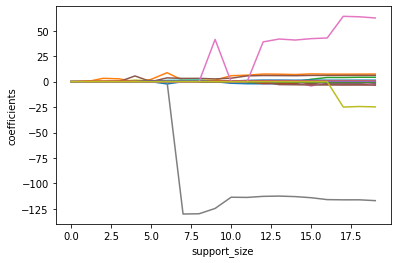

In [61]:
import matplotlib.pyplot as plt

coef = np.zeros((20, 19))
ic = np.zeros(20)
for s in range(20):
    model = abessLm(support_size = s)
    model.fit(x, y)
    coef[s, :] = model.coef_
    ic[s] = model.ic_

for i in range(19):
    plt.plot(coef[:, i], label = i)

plt.xlabel('support_size')
plt.ylabel('coefficients')
# plt.legend() # too long to plot
plt.show()


Besides, we can also generate a graph about the tuning value. Remember that we used the default EBIC to tune the support size.

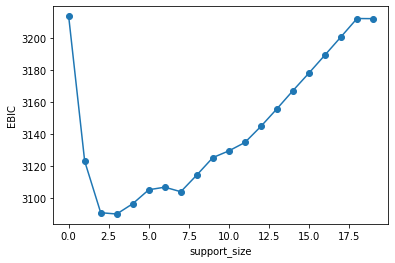

In [62]:
plt.plot(ic, 'o-')
plt.xlabel('support_size')
plt.ylabel('EBIC')
plt.show()

In EBIC criterion, `support_size = 4` has the lowest value, so the process adaptively choose 4 variables. Note that under other information criterion, the result may be different. 

## R tutorial 

For R tutorial, please view [https://abess-team.github.io/abess/articles/v01-abess-guide.html](https://abess-team.github.io/abess/articles/v01-abess-guide.html).